# Using glikonal in a real world setting

This notebook shows how to compute the minimal altitude for safe re-entry in an airfield, for gliding flight and in presence of obstacels, such as mountains.
Throughout the notebook we will use the airfield of Montricher (LSTR) as an example. However the same procedure can be applied to any other part of the world.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import glikonal_mrap as mrap
from numba import jit

In [2]:
#the algorithm operates o a grid, with discrete indices. However we would like to use geographical coordinates to identify points on the grid. Hence we need a couple auxiliary functions to convert geographical coordinates into indices and vice versa
def coordinates_to_indices(longitude, latitude, lower_left_longitude, lower_left_latitude, upper_right_longitude,upper_right_latitude,H,W):
    """
    function to convert geographical coordinates to indices on a grid. 
    WARNING: this function will not work if the area of interest contains the 180th meridian
    """
    if(lower_left_longitude>upper_right_longitude):
        raise Exception('Right side is more east than left side')
    id_y=int((latitude-lower_left_latitude)*H/(upper_right_latitude-lower_left_latitude))
    id_x=int((longitude-lower_left_longitude)*W/(upper_right_longitude-lower_left_longitude))
    #print((longitude-lower_left_longitude)*H/(upper_right_longitude-lower_left_longitude))
    if(id_x>W or id_x<0):
        raise Exception("Index out of map bounds")
    if(id_y>H or id_y<0):
        raise Exception("Index out of map bounds")
    return id_x, id_y

def indices_to_coordinates(id_x,id_y, lower_left_longitude, lower_left_latitude, upper_right_longitude,upper_right_latitude,H,W):
    """
    Function to convert indices on a grid to geographical coordinates. 
    WARNING: this function will not work if the area of interest contains the 180th meridian.
    """
    latitude=lower_left_latitude+id_x/W*(upper_right_latitude-lower_left_latitude)
    longitude=lower_left_longitude+id_y/H*(upper_right_longitude-lower_left_longitude)
    return longitude,latitude

# Download topography data.
We will be using the free database AW3D30 created using the satellite .The database registers the elevation of points on earth every arcsecond of latitude (about 30 m) and longitude (about 30 m at the equator). For more information see 
(https://www.eorc.jaxa.jp/ALOS/en/dataset/aw3d30/aw3d30_e.htm)

The data for the surroundings of the LSTR airfield are already downloaded and they're placed in the same folder as this notebook under the name "output_AW3D30.tif". THerefore if you're only interested in this region you cqn disregard the procedure below.
1. Go to https://portal.opentopography.org/datasetMetadata?otCollectionID=OT.112016.4326.2, or go to https://opentopography.org/ search for "AW3D30" and click on the entry "ALOS World 3D - 30m".
2. In the section "Download and Access Products:" click on "AW3D30", this will open a new page
3. In the section "Coordinates" select "Manually select coordinates". This will allow us to download elevation data only for the rectangle of selected coordinates. For LSTR input the values 6,46,7,47  (in this order) in the four fields. then click "Validate coordinates and estimate area". This should show you the selected region in a map above. In the following we will refer to these four coordinted as respectively `ll_lon_tile`, `ll_lat_tile`, `ur_lon_tile`, `ur_lat_tile`, where `ll` stands for "lower left", `ur` stands for "upper right", "lat stands for "latitude" and "lon" stands for "longitude". These refer to the coordinates of the corners of the rectangle.
4. Select GeoTiff as data output format
5. Enter your email address and click on "Submit", this will send the request of the data and it will open a new page. After the process has completed download the zipped data. 
6. Unzip the data  (we will assume that the file is named "output_AW3D30.tif") and place then in the same folder as this notebook.
7. Run the next cells to load the data nito the program.

In [3]:
# Specify the file path to the DSM (Digital Surface Model) file
dsm_filename= "../elevation_data/output_AW3D30.tif"
# Open the DSM file using rasterio
with rasterio.open(dsm_filename) as src:
    # Read the DSM data as a 2D NumPy array
    dsm_data = src.read(1)
# Print the shape and data type of the DSM array
print("DSM Shape:", dsm_data.shape)
print("DSM Data Type:", dsm_data.dtype)
dsm_data=dsm_data[::-1,:]
#use lower_left upper_right convention for coordinates


DSM Shape: (3600, 3600)
DSM Data Type: int16


### Select region of interest
The data we downloaded covers a region called a "tile", however we're interested in a smaller region inside the tile. In this cell, using the variables `ll_lon_tile`, `ll_lat_tile`, `ur_lon_tile`, `ur_lat_tile` we select the rectangle on which we run the algorithm. In the case of LSTR we select a region including the airport and part of the Jura mountain chain.

In [4]:
#data about the tile
H_tile,W_tile=dsm_data.shape
#the following coordinated should be matched with the ones of the downloaded tile.
ll_lon_tile=6 #longitude of the lower left corner of the tile
ll_lat_tile=46 #latitude of the lower left corner of the tile
ur_lon_tile=7 #longitude of the upper right corner of the tile
ur_lat_tile=47 #latitude of the upper right corner of the tile

#select portion of tile to run algorithm on
#these four coordinates select the portion of tile to consider
ll_lon=6
ll_lat=46.4
ur_lon=6.6
ur_lat=46.8
id_x_ll, id_y_ll=coordinates_to_indices(longitude=ll_lon, latitude=ll_lat, lower_left_longitude=ll_lon_tile, lower_left_latitude=ll_lat_tile, upper_right_longitude=ur_lon_tile,upper_right_latitude=ur_lat_tile,H=H_tile,W=W_tile)
id_x_ur, id_y_ur=coordinates_to_indices(longitude=ur_lon, latitude=ur_lat, lower_left_longitude=ll_lon_tile, lower_left_latitude=ll_lat_tile, upper_right_longitude=ur_lon_tile,upper_right_latitude=ur_lat_tile,H=H_tile,W=W_tile)
dsm_data_cropped=dsm_data[id_y_ll:id_y_ur,id_x_ll:id_x_ur]
# W,H are respectively the number of horizontal and vertical points in the selected region.
W=id_x_ur-id_x_ll 
H=id_y_ur-id_y_ll
print(f"Selected region: longitudes:[{ll_lon}, {ur_lon}] latitudes: [{ll_lat}, {ur_lat}].")
print(f"W={W}, H={H}") 

Selected region: longitudes:[6, 6.6] latitudes: [46.4, 46.8].
W=2159, H=1440


We now compute the scale of the map ,i.e., the correspondence between spacing on the grid and meters.
The data is collected taking a measure every arcsecond. When moving N-S the spacing between points is uniform in the map and is equal to 30.83 meters.
When moving E-W the length in meters of one arcsecond changes with the latitude: it is zero at the poles and 30.922 m at the equator. At intermediate latitudes it is computed below.
We will use a uniform scale across our selected region (i.e. we will pretend all of our selected region is found at the same latitude). This will imply that we'll make a small error in computing distances when going E-W.
The magnitude of this error (in percentage) is reported below. In most cases it will be smaler than 1%.


P.S. the spacing between ponit is one arcsecond at intermediate altitudes, towards the poles the spacingg in longitude between two measurements increases. Before using the data consult documentation of the dataset at (https://www.eorc.jaxa.jp/ALOS/en/dataset/aw3d30/aw3d30_e.htm).

In [5]:
mean_latitude=(ll_lat+ur_lat)/2 #mean latitude of the map in degrees. This is used to compute the x scale of the map. The x scale is assumed to be uniform.
hx=30.922*np.cos(mean_latitude*np.pi/180) #meters corresponding to an arcsecond of longitude, at the latitude 'mean_latitude'
hy=30.83 #meters corresponding to an arcsecond of latitude

hx_max=30.922*np.cos(ll_lat*np.pi/180)
hx_min=30.922*np.cos(ur_lat*np.pi/180)
delta_h=np.maximum(np.abs(hx-hx_max),np.abs(hx-hx_min))
print(f"Maximal distance distortion from assuming uniform scale: {100*delta_h/hx:.4f}%")

x=np.linspace(0,W*hx,W)
y=np.linspace(0,H*hy,H)
xx,yy=np.meshgrid(x,y)
print(f"horizontal (E-W) spacing ={hx:.2f} m ")
print(f"vertical (N-S) spacing ={hy:.2f} m ")

Maximal distance distortion from assuming uniform scale: 0.3697%
horizontal (E-W) spacing =21.25 m 
vertical (N-S) spacing =30.83 m 


We are now ready to plot the elevation profile. 
In the case of LSTR the dark region in the bottom right is the Lac Léman, insted the brightest point in the middle is the top of Mont Tendre.

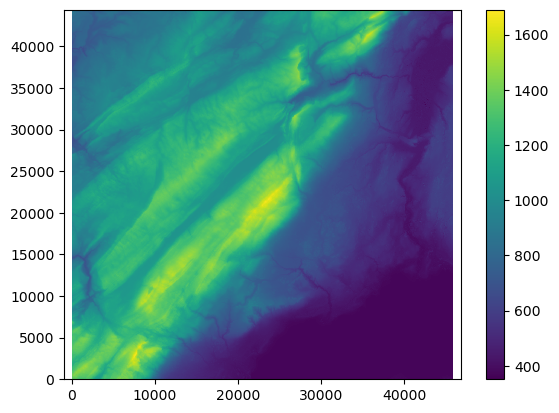

In [6]:
plt.figure()
plt.pcolormesh(xx,yy,dsm_data_cropped)
plt.axis('equal')
plt.colorbar()
#all the units are meters. Distances are measured from the bottom left corner of the tile.

### Interpolating the elevation data in a square grid
Our implementation of the MRAP algorithm is unable to deal with a rectangular grid (in the sense that the spacing between nodes are different in the x and y directions). For this reason we move the data onto a square grid.

In [7]:

def interpolate_on_square_grid(data,hx,hy,h):
    """
    Function to interpolate data on a square grid. The data is assumed to be on a regular grid, with horizontal spacing hx and vertical spacing hy. The output is a square grid of size HxW. The interpolation is linear.
    Args:
    data: 2D numpy array of size HxW containing the data to interpolate (first index has spacing hy).
    hx: float, horizontal spacing of the input grid.
    hy: float, vertical spacing of the input grid.
    h: float, target spacing of the output grid.

    Returns:
    output: 2D numpy array of size HxW containing the interpolated data. The interpolation is linear.
    """
    #initialize the output
    Hold,Wold=data.shape
    #H=int((Hold-1)*hy/h)+1
    #W=int((Wold-1)*hx/h)+1

    H=int(hy/h*Hold)
    W=int(hx/h*Wold)
    output=np.zeros((H,W))
    for y in range(H):
        for x in range(W):
            #compute the coordinates of the point in the output grid
            x_out=x*h
            y_out=y*h
            #compute the coordinates of the point in the input grid
            x_in=x_out/hx
            y_in=y_out/hy
            #compute the indices of the four points in the input grid that surround the point in the output grid
            x_in_floor=int(np.floor(x_in))
            y_in_floor=int(np.floor(y_in))
            x_in_ceil=min(int(np.ceil(x_in)),Wold-1)
            y_in_ceil=min(int(np.ceil(y_in)),Hold-1)
            #compute the weights of the four points in the input grid
            #we use a linear interpolation between the four points
            dx_in=(x_in-x_in_floor)/hx
            dy_in=(y_in-y_in_floor)/hy
            w_SW=(1-dx_in)*(1-dy_in)
            w_SE=dx_in*(1-dy_in)
            w_NW=(1-dx_in)*dy_in
            w_NE=dx_in*dy_in
            #compute the value of the point in the output grid
            output[y,x]=w_SW*data[y_in_floor,x_in_floor]+w_SE*data[y_in_floor,x_in_ceil]+w_NW*data[y_in_ceil,x_in_floor]+w_NE*data[y_in_ceil,x_in_ceil]

    return output

#aa=np.array([[0,1,2],[3,4,5],[6,7,8]])
#interpolate_on_square_grid(aa,1,1,0.5)




def max_interpolate_on_square_grid(data,hx,hy,h):
    """
    Function to interpolate data on a square grid. The data is assumed to be on a regular grid, with horizontal spacing hx and vertical spacing hy. The output is a square grid of size HxW. The algorithm uses max interpolation, i.e., the value of the output grid is the maximum of the values of the input grid that are contained in the cell of the output grid.
    If the cell of the output grid contains no point of the input grid, then the value of the output grid is the value of the input grid that is closest to the center of the cell.
    
    Args:
    data: 2D numpy array of size HxW containing the data to interpolate (first index has spacing hy).
    hx: float, horizontal spacing of the input grid.
    hy: float, vertical spacing of the input grid.
    h: float, target spacing of the output grid.

    Returns:
    output: 2D numpy array of size HxW containing the interpolated data. Max interpolation.
    """
    #initialize the output
    Hold,Wold=data.shape
    H=int(hy/h*Hold)
    W=int(hx/h*Wold)

    #H=int((Hold-1)*hy/h)+1
    #W=int((Wold-1)*hx/h)+1
    output=np.zeros((H,W))
    for y in range(H):
        for x in range(W):
            #compute the coordinates of the point in the output grid
            x_out=x*h
            y_out=y*h
            #compute the coordinates of the point in the input grid
            x_in=x_out/hx
            y_in=y_out/hy
            #compute the square of size h around the point
            x_out_max=min(x_out+h/2,W*h)
            y_out_max=min(y_out+h/2,H*h)
            x_out_min=max(x_out-h/2,0)
            y_out_min=max(y_out-h/2,0)
            #check if there is at least one point in the input grid that is contained in the square
            id_x_in_max=int(np.floor(x_out_max/hx))
            id_y_in_max=int(np.floor(y_out_max/hy))
            id_x_in_min=int(np.ceil(x_out_min/hx))
            id_y_in_min=int(np.ceil(y_out_min/hy))
            #print(id_x_in_min,id_x_in_max,id_y_in_min,id_y_in_max)
            # if there is at least one point in the input grid that is contained in the square, then we compute the maximum of the values of the input grid that are contained in the square
            if(id_x_in_min<=id_x_in_max and id_y_in_min<=id_y_in_max):
                output[y,x]=data[id_y_in_min:id_y_in_max+1,id_x_in_min:id_x_in_max+1].max()
            #otherwise we set the output to the value of the input closest to the center of the square
            else:
                output[y,x]=data[round(y_in),round(x_in)]
    return output



In [9]:
h=60 #target spacing of the output grid
dsm_data_cropped_square=max_interpolate_on_square_grid(dsm_data_cropped,hx,hy,h)
H,W=dsm_data_cropped_square.shape #size of the output grid

# Minimal return altitude
We compute the minimal altitude to return to the airfield from every point in the map


In [10]:
minimal_enroute_height=200 #meters. This is the minimal height above the terrain that the glider must maintain at all points of the trajectory. This is a safety margin to avoid collisions with the terrain.
minimal_altitude_above_airport=1000 #meters. This is the minimal altitude at which the glider has to be above the airport.
#airfield coordinates for LSTR (altitude 664m)
airfield_lon=6.40050
airfield_lat=46.59040
g=20 #assumed glide ratio of the glider.


airfield_id_x,airfield_id_y=coordinates_to_indices(airfield_lon, airfield_lat, lower_left_longitude=ll_lon, lower_left_latitude=ll_lat, upper_right_longitude=ur_lon,upper_right_latitude=ur_lat,H=H,W=W)

elevation_corr=dsm_data_cropped_square+minimal_enroute_height
elevation_corr[airfield_id_y,airfield_id_x]=+minimal_altitude_above_airport
print(f"enroute minimal height= {minimal_enroute_height} m. (at all points the gliding trajectory must be at least {minimal_enroute_height} m above the terrain)")
print(f"minimal altitude above airport= {minimal_altitude_above_airport} m. (the glider must arrive at the airport at an altitude of at least {minimal_altitude_above_airport} m above mean sea level)")

enroute minimal height= 200 m. (at all points the gliding trajectory must be at least 200 m above the terrain)
minimal altitude above airport= 1000 m. (the glider must arrive at the airport at an altitude of at least 1000 m above mean sea level)


In [11]:
radius=300 #meters. Radius of the circle centered at the airport, where the solution is computed analytically using the point source HJB equation.
init_pos=(airfield_id_y,airfield_id_x)
init_altitude=elevation_corr[airfield_id_y,airfield_id_x]
init_nodes,init_values=mrap.point_source_HJB_uniform_solver_MRAP(init_pos,init_altitude,radius,H,W,h,g)
grid=mrap.FMM_MRAP(init_nodes, init_values, elevation_corr, h,g,H,W)


/var/folders/n8/dxqjckvd4wl4l8rpd0n20xrw0000gp/T/ipykernel_87958/863569877.py:5: UserWarning: The following kwargs were not used by contour: 'linewidth'
  CS=plt.contour(xx,yy,grid,levels=[1200,1500,1700,1800,1900,2000,2300,2500],colors='white',antialiased=True,linewidth=1) #changing the numbers in the list one can look at other altitude levels.
/var/folders/n8/dxqjckvd4wl4l8rpd0n20xrw0000gp/T/ipykernel_87958/863569877.py:8: RuntimeWarning: divide by zero encountered in divide
  grid_chars=np.einsum('ijk,ij->ijk',grid_chars,1./np.linalg.norm(grid_chars,axis=2))


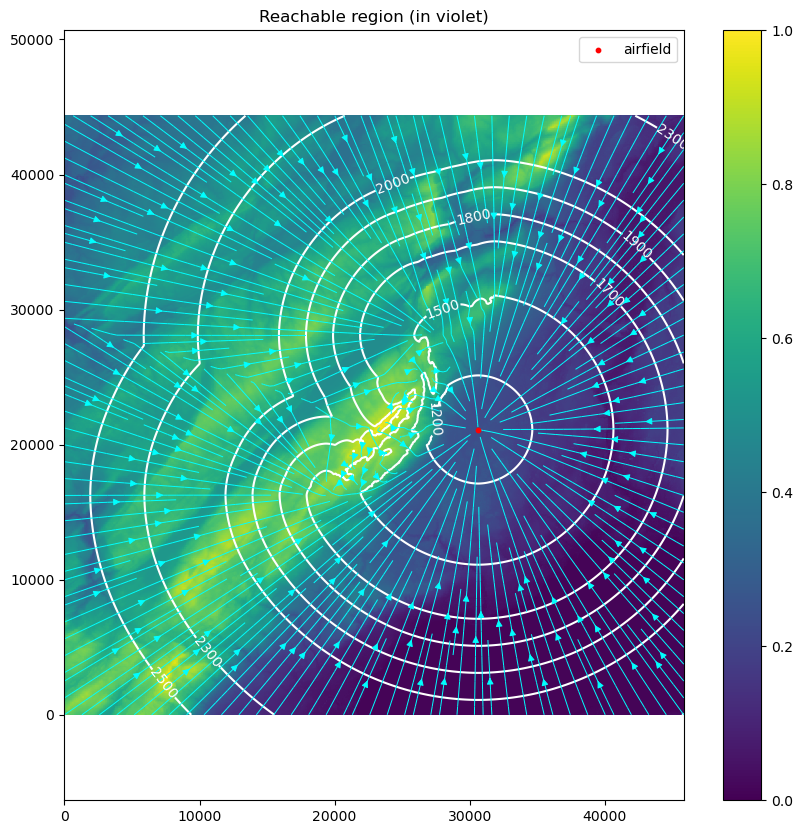

In [12]:
plt.figure(figsize=(10,10))
plt.axis('equal')
xx,yy=np.meshgrid(np.linspace(0,W*h,W),np.linspace(0,H*h,H))
plt.pcolormesh(xx,yy,dsm_data_cropped_square,cmap="viridis")
CS=plt.contour(xx,yy,grid,levels=[1200,1500,1700,1800,1900,2000,2300,2500],colors='white',antialiased=True,linewidth=1) #changing the numbers in the list one can look at other altitude levels.
plt.clabel(CS, CS.levels, inline=True, fontsize=10)
grid_chars=np.moveaxis(np.array(np.gradient(grid)),0,2)
grid_chars=np.einsum('ijk,ij->ijk',grid_chars,1./np.linalg.norm(grid_chars,axis=2))
#plt.clabel(CS, CS.levels, inline=True, fontsize=10)
plt.scatter(airfield_id_x*h,airfield_id_y*h,c="red",label="airfield",s=10,zorder=1000)
plt.streamplot(xx,yy,-grid_chars[:,:,1],-grid_chars[:,:,0],density=2.4,color='aqua',linewidth=0.7)

plt.legend()
plt.title("Reachable region (in violet)")
#plt.savefig("pics/single_peak_min_altitude.png",dpi=150,bbox_inches="tight")
plt.colorbar()

In [13]:
import pyvista as pv
rescale_z=6
X,Y=np.meshgrid(np.linspace(0,h*W,W),np.linspace(0,h*H,H))

# Create the first surface
surf1 = pv.StructuredGrid(X, Y, rescale_z*dsm_data_cropped_square)

# Create the second surface
surf2 = pv.StructuredGrid(X, Y, rescale_z*grid)

point=[h*init_pos[1],h*init_pos[0],rescale_z*dsm_data_cropped_square[airfield_id_y,airfield_id_x]]
point_cloud = pv.PolyData(point)

# Plot the surfaces
plotter = pv.Plotter()
plotter.add_mesh(surf2, color='green', opacity=0.6)
plotter.add_mesh(surf1, opacity=1,cmap="viridis")
plotter.add_mesh(point_cloud, color='red', point_size=10)
#plotter.camera_position=[[point[0],point[1],point[2]+200], [0, 0, 0], [0, 0, 1]]

# Show the plot
plotter.show()
print(plotter.camera_position)


Widget(value='<iframe src="http://localhost:64695/index.html?ui=P_0x7f9aa11ea730_0&reconnect=auto" class="pyvi…

[(96270.50818785472, 95520.50818785472, 83487.06325359647),
 (22925.0, 22175.0, 10141.555065741748),
 (0.0, 0.0, 1.0)]
